# Set Up

**Import libraries**

In [62]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Ignore warnings**

In [63]:
import warnings
warnings.filterwarnings("ignore")

**Load dataset**

In [64]:
JST_df = pd.read_excel("JSTdatasetR4.xlsx", sheet_name = "Data")

# Feature Engineering

**Precrisis indicator**

Crisis have to be predicted before they happen. If we focus on the years with crisis, model will fit the features when it's to late. In order to avoid this, is a good option to create a new target variable with positive value 2 years before a crisis.

In [65]:
def add_precrisis(df):
    df["precrisis"] = 0
    
    for i in range(1,df.shape[0]):
        if (df.loc[i, "crisisJST"] == 1):
            df.loc[(i-1), "precrisis"] = 1
            df.loc[(i-2), "precrisis"] = 1
    return df

JST_df = add_precrisis(JST_df)

**Features used in the model**

Obtain variables used in the model. This includes transformations and creation of new variables. Some variables are expressed as percentual growth since immediate value doesnt mean nothing, it's important to know how they change before a crisis. This way also scales a little bit the values between diferent countries.

In [66]:
def define_variables(df):
    # Slope of the yield curve
    df["slope"] = df["ltrate"] - df["stir"]
    
    # Global credit
    df["global_credit"] = 0
    for i in range(df.shape[0]):
        year_it = df.loc[(i), "year"] 
        df["global_credit"][i] = (df[df["year"] == year_it].tloans.sum() - df.loc[(i), "tloans"])/(df[df["year"] == year_it].tloans.shape[0] - 1)
    df["gr_global_credit"] = df["global_credit"].pct_change(periods = 2) / df["gdp"]
    
    # Log CPI
    df["log_cpi"] = np.log(df["cpi"])
    df["gr_log_cpi"] = df["log_cpi"].pct_change(periods = 2)
    
    # CA/GDP
    df["ca_gdp"] = df["ca"]/df["gdp"]
    df["gr_ca_gdp"] = df["ca_gdp"].pct_change(periods = 2)
    
    # Log RGDP
    df["log_real_gdp"] = np.log(df["rgdpmad"])
    df["gr_log_real_gdp"] = df["log_real_gdp"].pct_change(periods = 2)
    
    # Log money
    df["log_money"] = np.log(df["money"])
    df["gr_log_money"] = df["log_money"].pct_change(periods = 2)
    
    # Log Domestic Credit
    df["log_credit"] = np.log(df["tloans"])
    df["gr_log_credit"] = df["log_credit"].pct_change(periods = 2)
    
    # Inversion
    df["gr_inv"] = df["iy"].pct_change(periods = 2)
    
    # Acumulated Variance
    df["roll_credit"] = df.tloans.rolling(window=2 ,center=False).std()
    df["roll_money"] = df.money.rolling(window=2 ,center=False).std()
    df["roll_ltrate"] = df.ltrate.rolling(window=2 ,center=False).std()
    
    df["gr_gdp"] = df["gdp"].pct_change(periods = 2)
    
    return df

pre_df = define_variables(JST_df)

**Drop Bias PostCrisis**

Posterior period from a crisis is a recuperation time where economies are not healthy. Since they don't follow it's normal cycle, it's better to drop the 5 years after a crisis and the year of the crisis itself. By doing this it's easier to avoid possible bias.

In [67]:
def drop_crisis_bias(df):
    df["drops"] = 0
    
    for i in range(1,(df.shape[0])):
        if (df.loc[i, "crisisJST"] == 1):
            df.loc[i, "drops"] = 1
            df.loc[(i+1), "drops"] = 1
            df.loc[(i+2), "drops"] = 1
            df.loc[(i+3), "drops"] = 1
            df.loc[(i+4), "drops"] = 1
            df.loc[(i+5), "drops"] = 1  
            
    df = df[df["drops"] == 0]
    df = df.drop(["drops"], axis=1)
    return df

pre_df = drop_crisis_bias(pre_df)

**Possible Final features**

In [68]:
df = pre_df[["precrisis","slope","gr_global_credit","gr_log_cpi","ca_gdp","gr_log_real_gdp","gr_log_money",
            "gr_log_credit","gr_inv","year","country","stir","gr_ca_gdp","roll_credit","roll_money",
            "roll_ltrate","gr_gdp"]]

**Delete worst years**

Years of Great Depression and World Wars may be excluded from data since they are periods where economy doesnt follow a normal trend.

In [69]:
def drop_years(df):
    excluded_years = [1914,1915,1916,1917,1918,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945]
    df = df[~df["year"].isin(excluded_years)]
    return df

df = drop_years(df)

**Delete missing data**

In [70]:
df = df.replace(np.inf, np.NaN)
df.dropna(inplace=True)

**Simplification**

Simplify model to 6 nordic countries.

In [71]:
def select_country(df, paises):
    df = df[df["country"].isin(paises)]
    return df
df = select_country(df,["Norway","Switzerland","Finland","Germany","Denmark","Netherlands"])

Simplify to modern years (Post WWII).

In [72]:
df = df[df["year"] > 1949]

***Why log transformation?***

In [73]:
log_dataset_variables = ["ifs","year","country","crisisJST","precrisis",
                        "tloans","gdp","ltrate","money","stir","debtgdp",
                        "ca","cpi","iy","capital_tr","rconpc","rgdpmad",
                        "rgdppc"]
log_df = JST_df[log_dataset_variables]

log_df["log_tloans"] = np.log(JST_df["tloans"])
log_df["log_ltrate"] = np.log(JST_df["ltrate"])
log_df["log_money"] = np.log(JST_df["money"])
log_df["log_stir"] = np.log(JST_df["stir"])
log_df["log_debtgdp"] = np.log(JST_df["debtgdp"])
log_df["log_ca"] = np.log(JST_df["ca"])
log_df["log_cpi"] = np.log(JST_df["cpi"])
log_df["log_iy"] = np.log(JST_df["iy"])
log_df["log_capital_tr"] = np.log(JST_df["capital_tr"])
log_df["log_rconpc"] = np.log(JST_df["rconpc"])
log_df["log_rgdpmad"] = np.log(JST_df["rgdpmad"])
log_df["log_rgdppc"] = np.log(JST_df["rgdppc"])

Norway = log_df[log_df["country"] == "Norway"]
Switzerland = log_df[log_df["country"] == "Switzerland"]
Finland = log_df[log_df["country"] == "Finland"]
Germany = log_df[log_df["country"] == "Germany"]
Denmark = log_df[log_df["country"] == "Denmark"]
Netherlands = log_df[log_df["country"] == "Netherlands"]

In [74]:
def vs_country(df, feature, title):
    cris_values = df.crisisJST.values
    pre_values = df.precrisis.values
    
    clrs = ["blue" if (x == 1) else "orange" for x in cris_values]
    
    for i in range(0,len(pre_values)):
        if (pre_values[i] == 1):
            clrs[i] = "red"

    plt.figure(figsize=(10,6))
    ax = plt.bar(df.year, df[feature], label = df.crisisJST, color = clrs) 
    plt.title(title)
    
def vs_feature(df,features,title):
     
    for feature in features:
        vs_country(df,feature,"{}-{}".format(title,feature))

- Long scaled features normalized and standard deviation reduced.

7.030319943519664


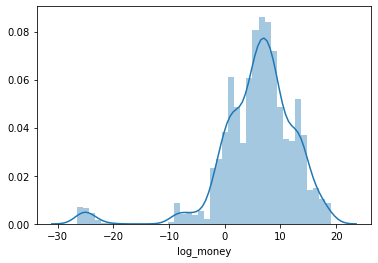

In [75]:
print(log_df["log_money"].std())
sns.distplot(log_df["log_money"])

14758446.505403975


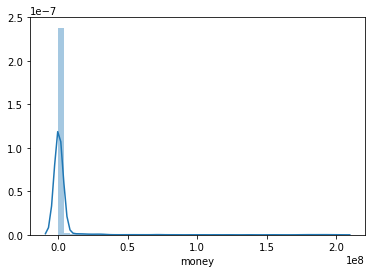

In [76]:
print(log_df["money"].std())
sns.distplot(log_df["money"])

- Make exponential variables more lineal.
- Make values more similar between countries aproximating its scale.

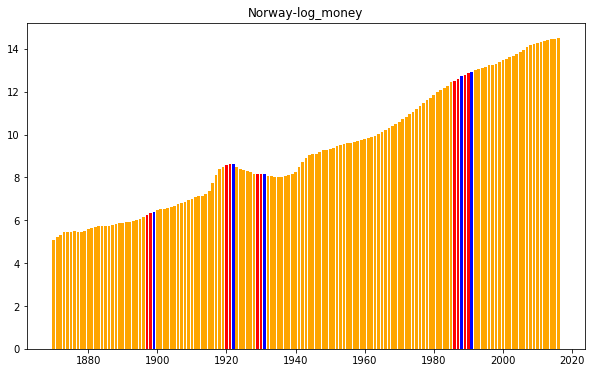

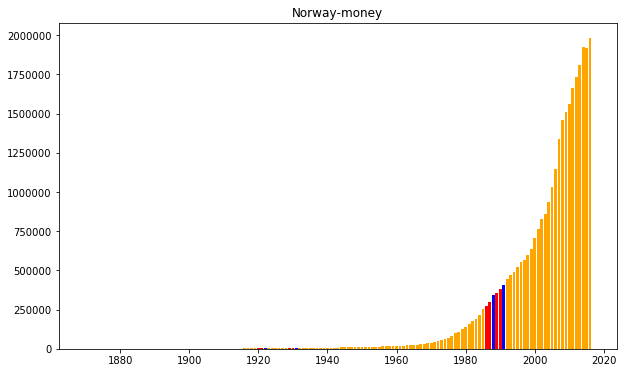

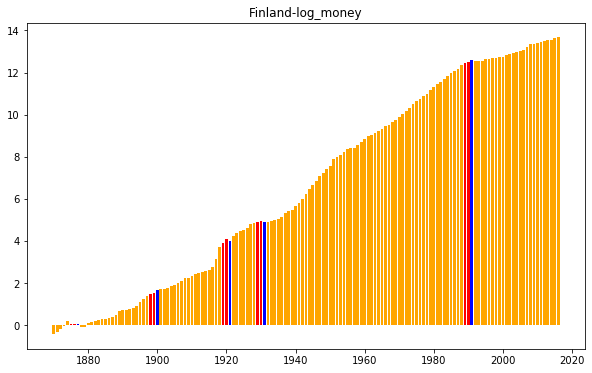

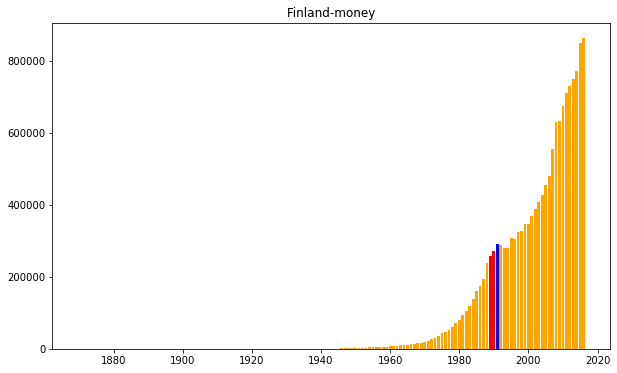

In [77]:
countries = [Norway, Finland]

for country in countries:
    vs_feature(country,["log_money", "money"], country.country.unique()[0])

- Change slightly low-scale data.

0.8054991047713267


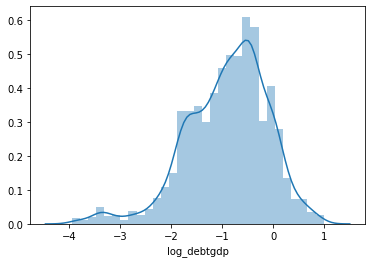

In [78]:
print(log_df["log_debtgdp"].std())
sns.distplot(log_df["log_debtgdp"])

0.3911732623546826


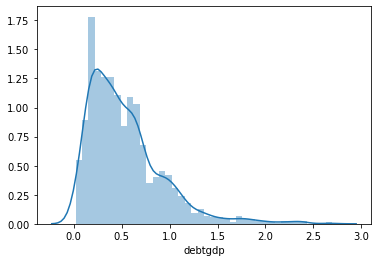

In [79]:
print(log_df["debtgdp"].std())
sns.distplot(log_df["debtgdp"])

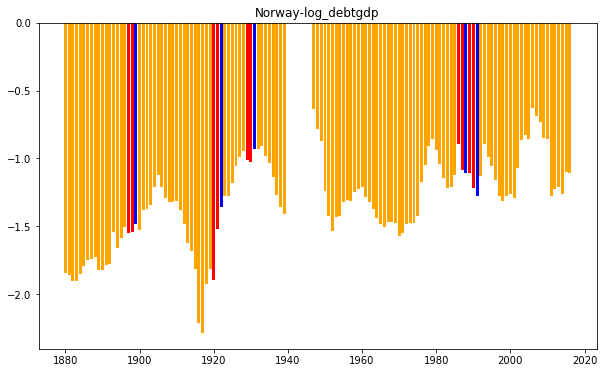

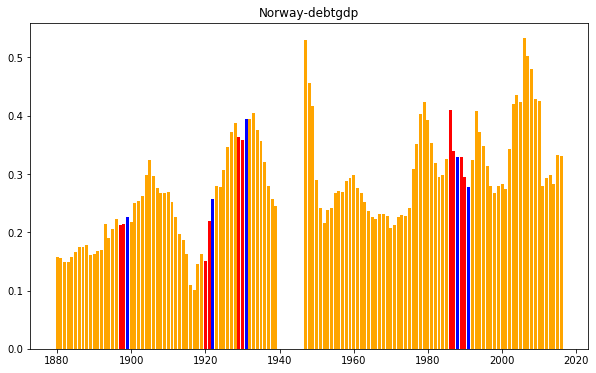

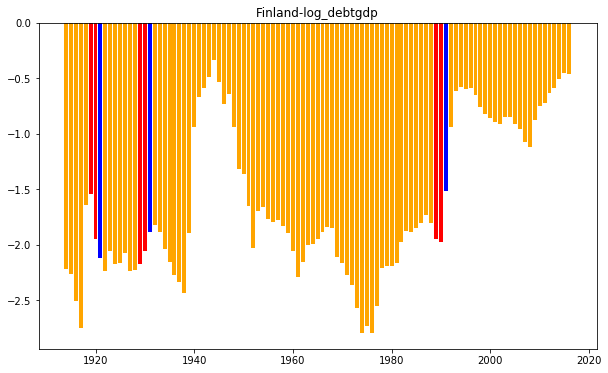

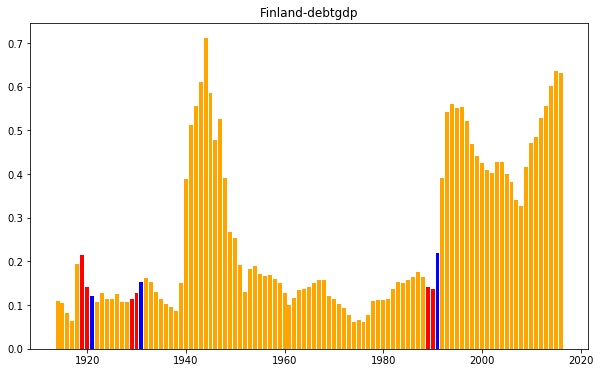

In [80]:
countries = [Norway, Finland]

for country in countries:
    vs_feature(country,["log_debtgdp", "debtgdp"], country.country.unique()[0])

# Model implementatión

**Classification function**

In [81]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,roc_auc_score


def classification(classifier, X, y):
    y_train_pred = cross_val_predict(classifier, X, y ,cv=5)
    print("Confusion matrix:")
    print(confusion_matrix(y, y_train_pred))
    print("AUC score:",roc_auc_score(y.values, y_train_pred))

Target and variables.

In [82]:
X = df[["slope","gr_global_credit","gr_log_cpi","ca_gdp","gr_log_real_gdp","gr_log_money",
            "gr_log_credit","gr_inv"]]

y = df["precrisis"]

**Logistic Regresion**

In [83]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, penalty=None, loss="log")

classification(sgd_clf, X, y)

Confusion matrix:
[[317  17]
 [ 15   1]]
AUC score: 0.5058008982035929


**Random Forest**

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42, n_estimators=1000)

classification(rf_clf, X, y)

Confusion matrix:
[[334   0]
 [ 14   2]]
AUC score: 0.5625


**Extremely randomised trees**

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

etc_clf = ExtraTreesClassifier(n_estimators=1000, random_state=22)

classification(etc_clf, X, y)

Confusion matrix:
[[333   1]
 [ 16   0]]
AUC score: 0.49850299401197606


**Neural network**

In [86]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(max_iter=1000, solver="lbfgs", random_state=42)

classification(mlp_clf,X,y)

Confusion matrix:
[[315  19]
 [ 13   3]]
AUC score: 0.565306886227545


**Extreme gradient boosting**

In [87]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(random_state=42,n_estimators = 1000, learning_rate=0.1,min_child_weight=5)

classification(xgb_clf, X ,y)

Confusion matrix:
[[332   2]
 [ 16   0]]
AUC score: 0.49700598802395207


# Optimal hyperparameters GridSearch

### Neural Network

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
param_grid = {"solver":["lbfgs","adam"],"learning_rate":["constant","invscaling","adaptative"],
              "random_state":[42],"activation":["identity","logistic","tanh","relu"],
             "alpha":[0.00001,0.0005,]}

mlp_clf = MLPClassifier()

grid_search = GridSearchCV(mlp_clf, param_grid, scoring="roc_auc", cv=5, return_train_score = True)

grid_search.fit(X,y)

print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'activation': 'identity', 'alpha': 1e-05, 'learning_rate': 'constant', 'random_state': 42, 'solver': 'adam'}
Score: 0.7948778833107191


In [90]:
print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'activation': 'identity', 'alpha': 1e-05, 'learning_rate': 'constant', 'random_state': 42, 'solver': 'adam'}
Score: 0.7948778833107191


### Logitstic Regresion

In [91]:
param_grid = {"loss":["hinge","log","squared_loss","huber","epsilon_insensitive"],
             "penalty":["l2","l1","elasticnet"],"max_iter":[500,1000,1500],
             "learning_rate":["optimal","constant","adaptive","invscaling"],
             "eta0":[0.00001,0.0001,0.005,0.1]}

clf = SGDClassifier()

grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=5, return_train_score = True)

grid_search.fit(X,y)

print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'eta0': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'elasticnet'}
Score: 0.8576888285843509


### Random Forest

In [92]:
param_grid = {"n_estimators":[50,100,300,500,1000,1500],"criterion":["gini","entropy"],
             "max_features":["auto","sqrt","log2"],"random_state":[42],
              "class_weight":["balanced","balanced_subsample",None]}

clf = RandomForestClassifier()

grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=5, return_train_score = True)

grid_search.fit(X,y)

print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 300, 'random_state': 42}
Score: 0.8622003618272274


###  Extremely randomised trees

In [93]:
param_grid = {"n_estimators":[50,100,300,500,1000,1500],"criterion":["gini","entropy"],
             "max_features":["auto","sqrt","log2"],"random_state":[42],
              "class_weight":["balanced","balanced_subsample",None]}

clf = ExtraTreesClassifier()

grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=5, return_train_score = True)

grid_search.fit(X,y)

print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 300, 'random_state': 42}
Score: 0.8760119855269111


### XGB

In [94]:
param_grid = {"random_state":[42],"sampling_method":["uniform","gradient_based"],
             "tree_method":["auto","exact","approx","hist","gpu_hist"],
             "grow_policy":['depthwise', 'lossguide'],
             "predictor":["auto","cpu_predictor","gpu_predictor"]}

clf = XGBClassifier()

grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", cv=5, return_train_score = True)

grid_search.fit(X,y)

print("Best params:",grid_search.best_params_)
print("Score:",grid_search.best_score_)

Best params: {'grow_policy': 'depthwise', 'predictor': 'cpu_predictor', 'random_state': 42, 'sampling_method': 'uniform', 'tree_method': 'approx'}
Score: 0.8565355042966983
